# CARGA DE LIBRERÍAS Y DATOS

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud 

In [26]:
# Cargo los datos que voy a usar.
df_steam_games = pd.read_parquet('..\\datasets\\2. Depurado\\steam_games_depurado.parquet')
df_users = pd.read_parquet('..\\datasets\\2. Depurado\\users_items_depurado.parquet')
df_reviews = pd.read_parquet('..\\datasets\\2. Depurado\\user_reviews_NLP.parquet')


- Se analizan outliers de price y de release_date.

In [27]:
df_steam_games.describe()

release_date         price        item_id  \
count                          28239  27329.000000        28542.0   
mean   2015-05-24 21:18:30.251779584      8.683993   440794.73821   
min              1983-06-19 00:00:00      0.000000           10.0   
25%              2014-10-23 00:00:00      2.990000       317722.5   
50%              2016-04-22 00:00:00      4.990000       435105.5   
75%              2017-04-19 00:00:00      9.990000       586317.5   
max              2021-12-31 00:00:00    995.000000      2028850.0   
std                              NaN     14.644351  185186.713436   

               year  
count  28239.000000  
mean    2014.848649  
min     1983.000000  
25%     2014.000000  
50%     2016.000000  
75%     2017.000000  
max     2021.000000  
std        3.271175

In [28]:
df_steam_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28542 entries, 0 to 28541
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   publisher     23649 non-null  object        
 1   genres        28542 non-null  object        
 2   app_name      28541 non-null  object        
 3   title         28541 non-null  object        
 4   url           28542 non-null  object        
 5   release_date  28239 non-null  datetime64[ns]
 6   tags          28542 non-null  object        
 7   reviews_url   28542 non-null  object        
 8   specs         28542 non-null  object        
 9   price         27329 non-null  float64       
 10  early_access  28542 non-null  bool          
 11  item_id       28542 non-null  Int64         
 12  developer     28372 non-null  object        
 13  free          28542 non-null  bool          
 14  year          28239 non-null  float64       
dtypes: Int64(1), bool(2), datetime64[ns]

# ANÁLISIS UNIVARIADO:

- "release_date" tiene fechas razonables. Se presentaron dudas sobre la fecha más vieja, 15/07/1970, pero se verifica en la web.

<img src="../_src/Juego_Más_Viejo.PNG" height="300"><br>

In [29]:
df_steam_games[df_steam_games['release_date'] == df_steam_games['release_date'].min()]

publisher                       genres       app_name  \
1329  Digital Leisure Inc.  [Action, Adventure, Casual]  Dragon's Lair   

              title                                                url  \
1329  Dragon's Lair  http://store.steampowered.com/app/227380/Drago...   

     release_date                                               tags  \
1329   1983-06-19  [Adventure, Action, FMV, Casual, Quick-Time Ev...   

                                            reviews_url  \
1329  http://steamcommunity.com/app/227380/reviews/?...   

                                                  specs  price  early_access  \
1329  [Single-player, Steam Achievements, Partial Co...   9.99         False   

      item_id             developer   free    year  
1329   227380  Digital Leisure Inc.  False  1983.0

- "price": si bien la media es baja, los valores extremos no parecieran estar errados, es razonable que un juego pueda valer 995 USD. Se verifica en la web.

<img src="../_src/Juego_Más_Caro.PNG" height="300"><br>

In [30]:
df_steam_games[df_steam_games['price'] == df_steam_games['price'].max()]['url']

10754    http://store.steampowered.com/app/719000/Strat...
Name: url, dtype: object

- Se realiza un histograma y un boxplot para visualizar todos los valores.

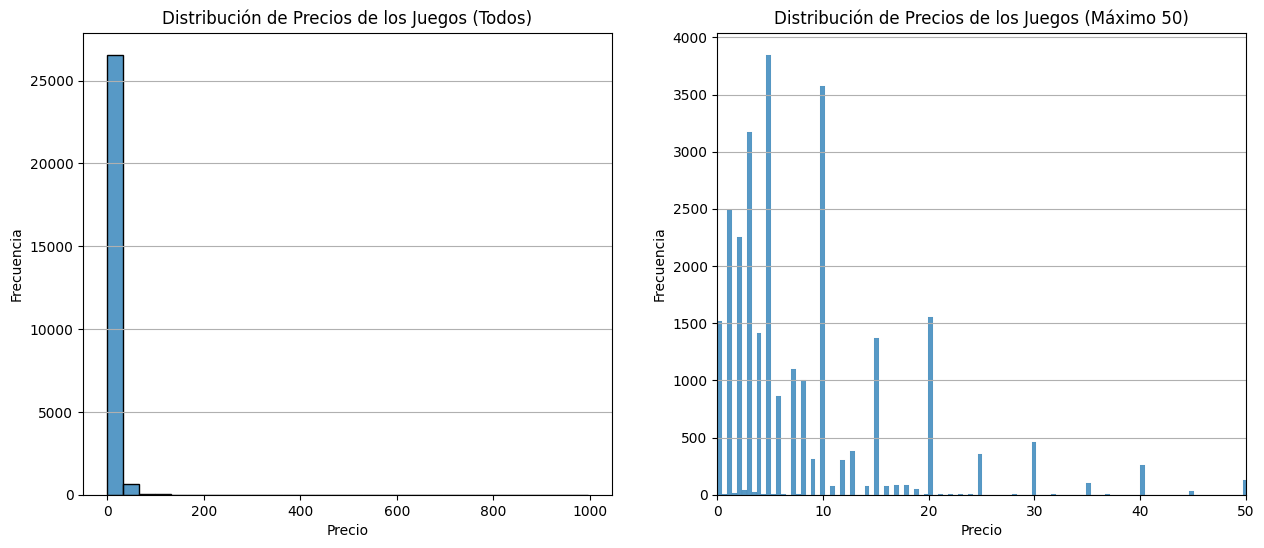

In [31]:
# Hago el histograma  para visulizarlo
# Creo la figura y los subgráficos
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=False)

# Primer histograma con todos los precios
sns.histplot(df_steam_games['price'], bins = 30, ax=axes[0])
axes[0].set_title('Distribución de Precios de los Juegos (Todos)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_xlabel('Precio')
axes[0].grid(axis='y')

# Segundo histograma recortado a un precio máximo de 20 - No fuerzo los bins, limito aa 50
sns.histplot(df_steam_games['price'],  ax=axes[1])
axes[1].set_title('Distribución de Precios de los Juegos (Máximo 50)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_xlabel('Precio')
axes[1].grid(axis='y')
axes[1].set_xlim(0, 50)

plt.show()

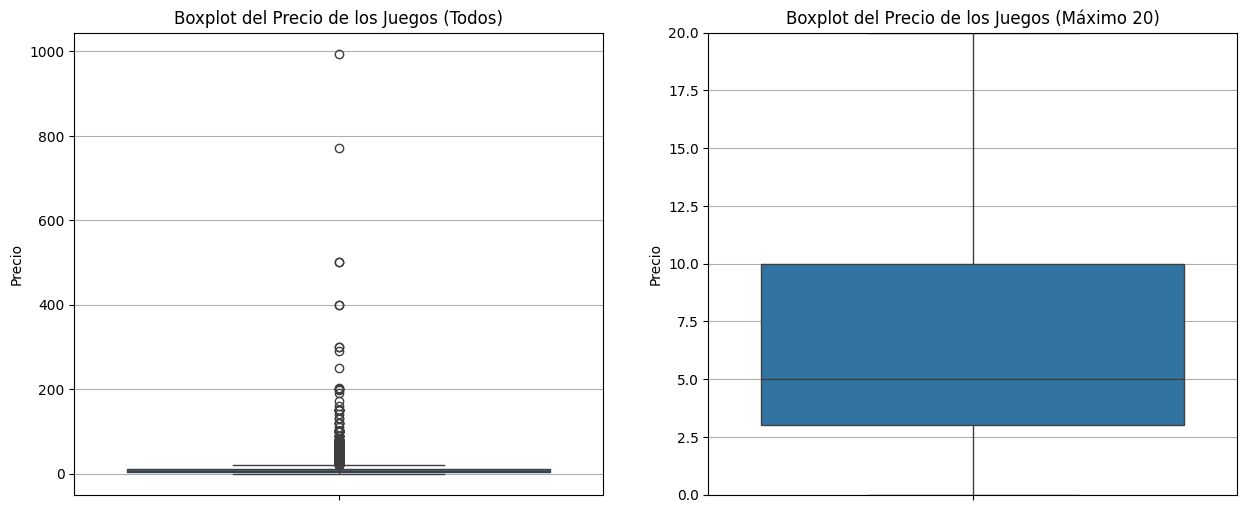

In [32]:
# Creo un boxplot para la columna 'price' usando seaborn
# Creo la figura y los subgráficos
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Primer boxplot con todos los precios
sns.boxplot(y=df_steam_games['price'], ax=axes[0])
axes[0].set_title('Boxplot del Precio de los Juegos (Todos)')
axes[0].set_ylabel('Precio')
axes[0].grid(axis='y')

# Segundo boxplot recortado a un precio máximo de 20
sns.boxplot(y=df_steam_games['price'], ax=axes[1])
axes[1].set_title('Boxplot del Precio de los Juegos (Máximo 20)')
axes[1].set_ylabel('Precio')
axes[1].grid(axis='y')
axes[1].set_ylim(0, 20)

# Mostrar los gráficos
plt.show()


- Cuento la cantidad de juegos por género, por specs y por tags:
    - Se observan valores que no son referidos al género del juego en sí mismo, como por ejemplo:
        - Free to play
        - Early Access
    - Se toma la decisión de eliminar estos valores dentro de la columna genres.

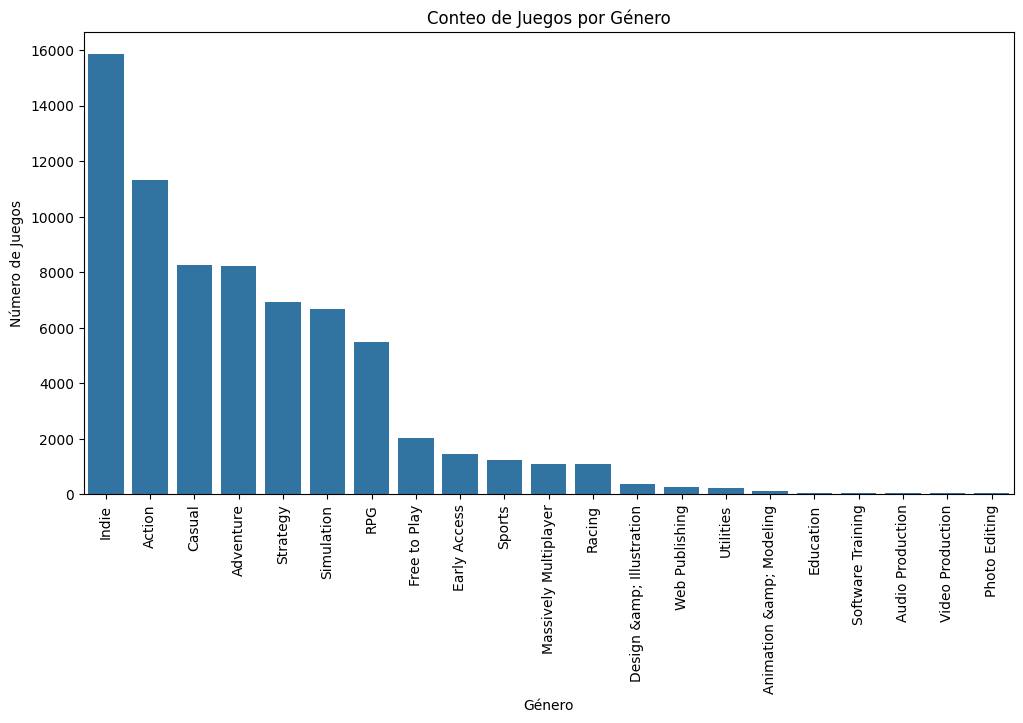

In [33]:
# Paso los géneros a una lista.
genre_counts = df_steam_games['genres'].explode().value_counts()

# Grafico la cantidad de jeugos por género
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xticks(rotation=90)
plt.title('Conteo de Juegos por Género')
plt.xlabel('Género')
plt.ylabel('Número de Juegos')
plt.show()

In [34]:
# Elimino "Free to Play" y "Early Access" de la listas de género
df_steam_games['genres'] = df_steam_games['genres'].apply(lambda x: [genre for genre in x if (genre != 'Free to Play' and genre != 'Early Access')])

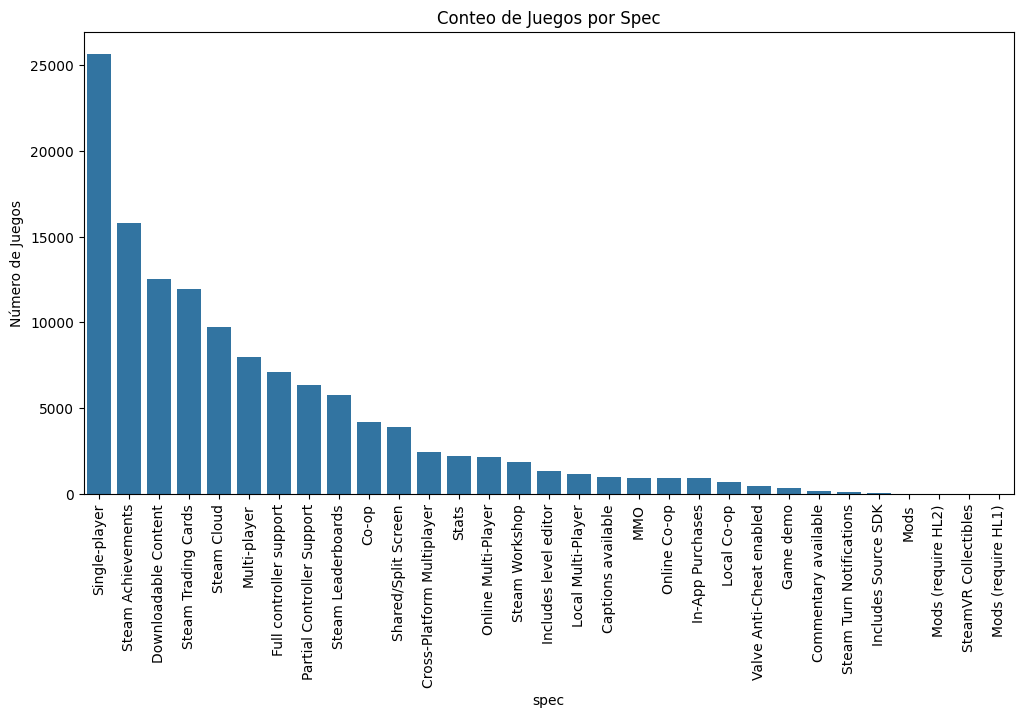

In [35]:
# Paso los specs a una lista.
genre_counts = df_steam_games['specs'].explode().value_counts()

# Grafico la cantidad de juegos por spec
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xticks(rotation=90)
plt.title('Conteo de Juegos por Spec')
plt.xlabel('spec')
plt.ylabel('Número de Juegos')
plt.show()

In [36]:
df_steam_games.head()

publisher                                         genres  \
0            Kotoshiro  [Action, Casual, Indie, Simulation, Strategy]   
1     Making Fun, Inc.                         [Indie, RPG, Strategy]   
2         Poolians.com            [Casual, Indie, Simulation, Sports]   
3                 彼岸领域                    [Action, Adventure, Casual]   
4  Trickjump Games Ltd                [Action, Adventure, Simulation]   

                  app_name                    title  \
0      Lost Summoner Kitty      Lost Summoner Kitty   
1                Ironbound                Ironbound   
2  Real Pool 3D - Poolians  Real Pool 3D - Poolians   
3                  弹炸人2222                  弹炸人2222   
4    Battle Royale Trainer    Battle Royale Trainer   

                                                 url release_date  \
0  http://store.steampowered.com/app/761140/Lost_...   2018-01-04   
1  http://store.steampowered.com/app/643980/Ironb...   2018-01-04   
2  http://store.steampowered.com/app/670290/Real_...   2017-07-24   
3     http://store.steampowered.com/app/767400/2222/   2017-12-07   
4  http://store.steampowered.com/app/772540/Battl...   2018-01-04   

                                                tags  \
0      [Strategy, Action, Indie, Casual, Simulation]   
1  [Free to Play, Strategy, Indie, RPG, Card Game...   
2  [Free to Play, Simulation, Sports, Casual, Ind...   
3                        [Action, Adventure, Casual]   
4  [Action, Adventure, Simulation, FPS, Shooter, ...   

                                         reviews_url  \
0  http://steamcommunity.com/app/761140/reviews/?...   
1  http://steamcommunity.com/app/643980/reviews/?...   
2  http://steamcommunity.com/app/670290/reviews/?...   
3  http://steamcommunity.com/app/767400/reviews/?...   
4  http://steamcommunity.com/app/772540/reviews/?...   

                                               specs  price  early_access  \
0                                    [Single-player]   4.99         False   
1  [Single-player, Multi-player, Online Multi-Pla...   0.00         False   
2  [Single-player, Multi-player, Online Multi-Pla...   0.00         False   
3                                    [Single-player]   0.99         False   
4                [Single-player, Steam Achievements]   3.99         False   

   item_id            developer   free    year  
0   761140            Kotoshiro  False  2018.0  
1   643980     Secret Level SRL   True  2018.0  
2   670290         Poolians.com   True  2017.0  
3   767400                 彼岸领域  False  2017.0  
4   772540  Trickjump Games Ltd  False  2018.0

- Como se puede observar, hay valores en tags que ya existen en specs y genres. Los voy a eliminar.

In [42]:
# Función para eliminar duplicados en la columna 'tags'
def remove_duplicate_tags(row):
    # Convertir los valores de genres, specs y tags a conjuntos
    genres_set = set(row['genres']) if isinstance(row['genres'], list) else set()
    specs_set = set(row['specs']) if isinstance(row['specs'], list) else set()
    tags_set = set(row['tags']) if isinstance(row['tags'], list) else set()

    # Restar los conjuntos de genres y specs de tags
    cleaned_tags = tags_set - genres_set - specs_set
    
    # Si cleaned_tags está vacío, devolver una lista vacía, de lo contrario, devolver la lista de cleaned_tags
    return list(cleaned_tags) if cleaned_tags else []

# Lo convierto a listas
df_steam_games['specs'] = df_steam_games['specs'].apply(lambda x: [specs for specs in x ])
df_steam_games['tags'] = df_steam_games['tags'].apply(lambda x: [specs for specs in x ])
# Aplicar la función a cada fila del DataFrame
df_steam_games['tags_new'] = df_steam_games.apply(remove_duplicate_tags, axis=1)

# Elimino "Free to Play" y "Early Access" de la listas de género
df_steam_games['tags_new'] = df_steam_games['tags_new'].apply(lambda x: [tags_new for tags_new in x if (tags_new != 'Free to Play' and tags_new != 'Early Access')])


{'Single-player'}
{'Casual', 'Strategy', 'Action', 'Indie', 'Simulation'}
{'Steam Trading Cards', 'In-App Purchases', 'Steam Achievements', 'Multi-player', 'Single-player', 'Online Multi-Player', 'Cross-Platform Multiplayer'}
{'Strategy', 'Competitive', 'Fantasy', 'Turn-Based', 'Free to Play', '2D', 'Character Customization', 'Replay Value', 'Indie', 'RPG', 'Design & Illustration', 'Difficult', 'Female Protagonist', 'Dark Fantasy', 'PvP', 'Card Game', 'Board Game', 'Tactical', 'Trading Card Game'}
{'In-App Purchases', 'Stats', 'Multi-player', 'Single-player', 'Online Multi-Player'}
{'Free to Play', 'Casual', 'Sports', 'Multiplayer', 'Indie', 'Simulation'}
{'Single-player'}
{'Casual', 'Action', 'Adventure'}
{'Steam Achievements', 'Single-player'}
{'Third Person', 'Shooter', 'FPS', 'Third-Person Shooter', 'Sniper', 'Action', 'Adventure', 'Simulation'}
{'Steam Trading Cards', 'Steam Leaderboards', 'In-App Purchases', 'Steam Achievements', 'Steam Cloud', 'Full controller support', 'Multi-p

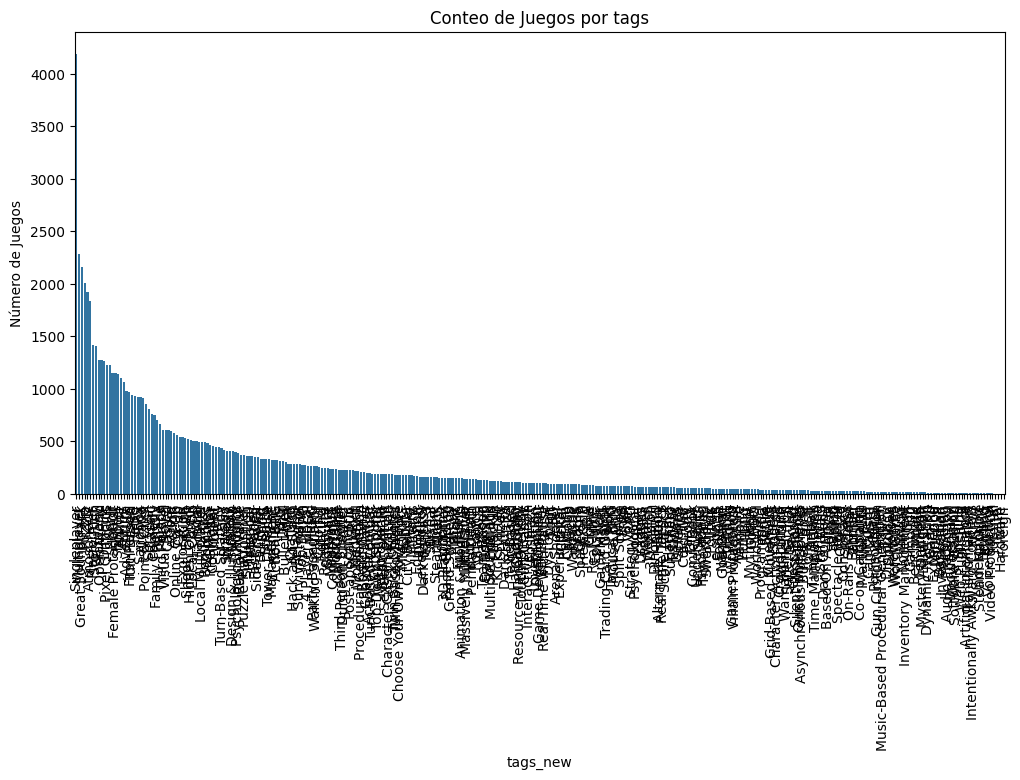

In [43]:
# Paso los tags a una lista.
genre_counts = df_steam_games['tags_new'].explode().value_counts()

# Grafico la cantidad de juegos por tags
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xticks(rotation=90)
plt.title('Conteo de Juegos por tags')
plt.xlabel('tags_new')
plt.ylabel('Número de Juegos')
plt.show()

In [303]:
# Paso los tags a una lista.
genre_counts = df_steam_games['tags'].explode()
print(genre_counts)

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
28537    NaN
28538    NaN
28539    NaN
28540    NaN
28541    NaN
Name: tags, Length: 28542, dtype: object


- Analizo la cantidad de juegos por año de publicación

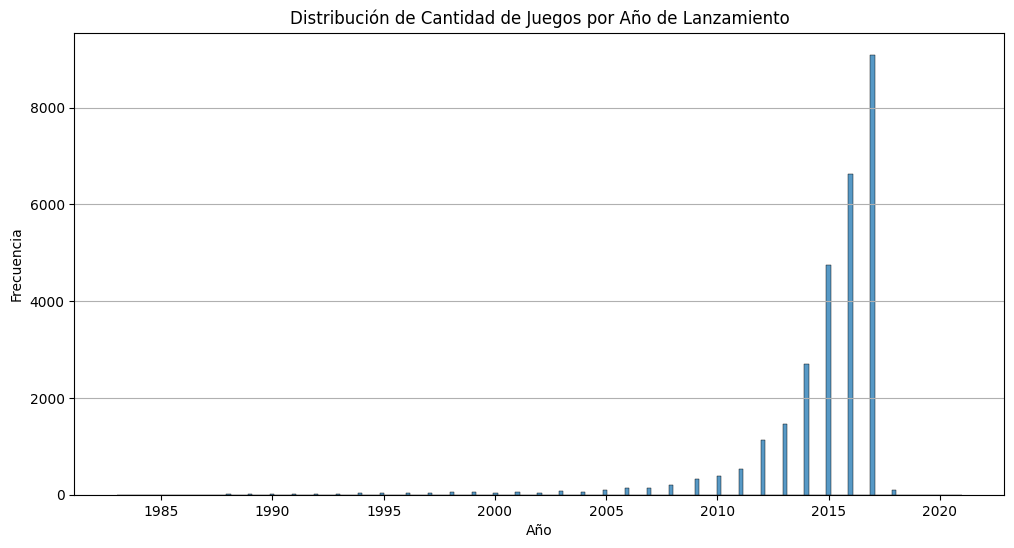

In [267]:
plt.figure(figsize=(12, 6))
sns.histplot(df_steam_games['year'])
plt.title('Distribución de Cantidad de Juegos por Año de Lanzamiento')
plt.ylabel('Frecuencia')
plt.xlabel('Año')
plt.grid(axis='y')

plt.show()

- Agrego algunas métricas al df para poder analizar otros resultados.

In [268]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58431 entries, 0 to 58430
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            58431 non-null  object
 1   user_url           58431 non-null  object
 2   item_id            58431 non-null  Int64 
 3   posted             58431 non-null  object
 4   helpful            58431 non-null  object
 5   recommend          58431 non-null  bool  
 6   funny              58431 non-null  object
 7   review             58431 non-null  object
 8   processed_reviews  58431 non-null  object
 9   sentiment          58431 non-null  object
 10  sentiment_value    58431 non-null  object
dtypes: Int64(1), bool(1), object(9)
memory usage: 4.6+ MB


In [269]:
# Voy a calcular métricas a partir de las reviews para cada juego.
# Calculo la cantidad de sentimientos "Positivos", "Neutros" y "Negativos" para cada juego y si no tiene pongo 0
sentiment_counts = df_reviews.groupby('item_id')['sentiment'].value_counts().unstack(fill_value=0)

# Calculo el total de reviews por juego (por columna)
sentiment_counts['total_reviews'] = sentiment_counts.sum(axis=1)

# Calculo la proporción de reviews por tipo de sentimiento por juego
sentiment_counts['positive_ratio'] = sentiment_counts.get('Positivo', 0) / sentiment_counts['total_reviews']
sentiment_counts['neutral_ratio'] = sentiment_counts.get('Neutro', 0) / sentiment_counts['total_reviews']
sentiment_counts['negative_ratio'] = sentiment_counts.get('Negativo', 0) / sentiment_counts['total_reviews']

# También necesito el total_reviews porque sino un juego que tiene una sola review positvia tiene un positive_ratio de 1.
# Voy a joinear las métricas de sentimiento al dataframe de juegos
df_steam_games = df_steam_games.merge(sentiment_counts[['positive_ratio', 'neutral_ratio', 'negative_ratio','total_reviews']], on='item_id', how='left')

In [270]:
recomends_counts = df_reviews.groupby('item_id')['recommend'].value_counts().unstack(fill_value=0)

# Calculo el total de reviews por juego (por columna)
recomends_counts['total_recommend'] = sentiment_counts.sum(axis=1)

# Calculo la proporción de reviews por tipo de sentimiento por juego
recomends_counts['true_ratio'] = recomends_counts.get(True, 0) / recomends_counts['total_recommend']
recomends_counts['false_ratio'] = recomends_counts.get(False, 0) / recomends_counts['total_recommend']

# También necesito el total_reviews porque sino un juego que tiene una sola review positvia tiene un positive_ratio de 1.
# Voy a joinear las métricas de sentimiento al dataframe de juegos
df_steam_games = df_steam_games.merge(recomends_counts[['true_ratio', 'false_ratio','total_recommend']], on='item_id', how='left')


In [271]:
# # Voy a calcular la cantidad de TOTAL de tiempo jugado entre todos los user_id para cada juego
total_time = df_users.groupby('item_id')['playtime_forever'].sum()

# Voy a joinear las métricas de tiempo al dataframe de juegos
df_steam_games = df_steam_games.merge(total_time, on='item_id', how='left')

- Análisis de juegos más jugados:

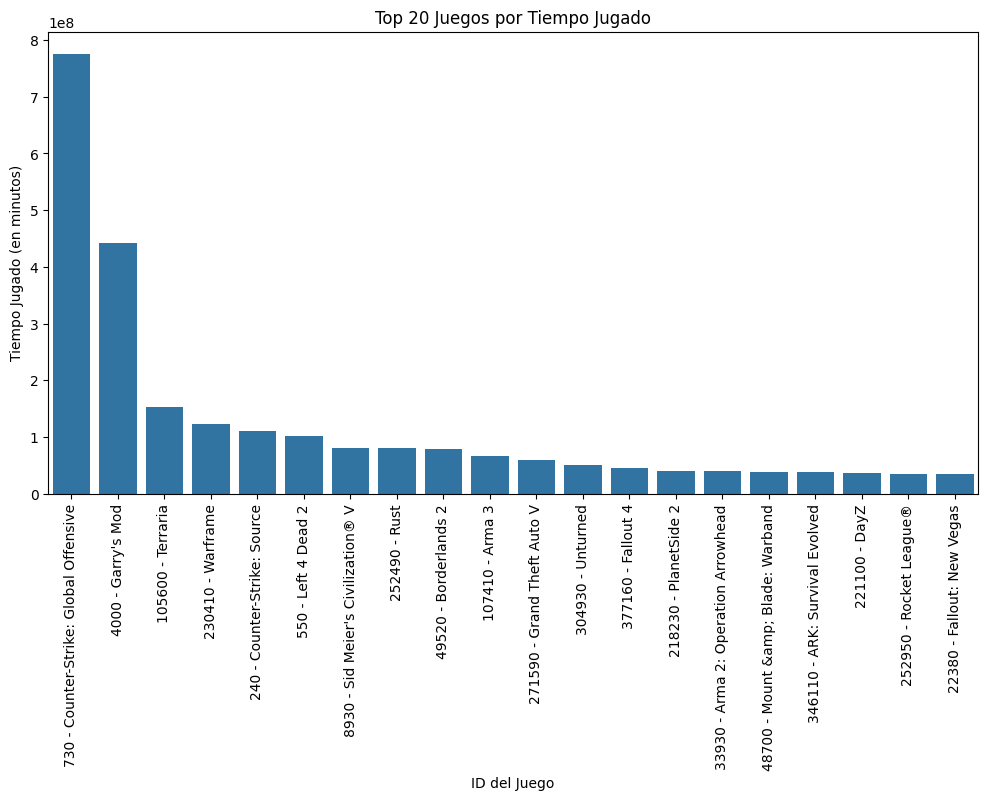

In [272]:
# Ordeno el DataFrame por 'playtime_forever' y seleccionar los primeros 20 juegos
top_20_playtime = df_steam_games.sort_values(by='playtime_forever', ascending=False).head(20)

# Crear una nueva columna que combine 'item_id' y 'title'
top_20_playtime['game_label'] = top_20_playtime['item_id'].astype(str) + ' - ' + top_20_playtime['title']

# Graficar la cantidad de tiempo por juego
plt.figure(figsize=(12, 6))
sns.barplot(x= top_20_playtime['game_label'] , y=top_20_playtime['playtime_forever'])
plt.xticks(rotation=90)
plt.title('Top 20 Juegos por Tiempo Jugado')
plt.xlabel('ID del Juego')
plt.ylabel('Tiempo Jugado (en minutos)')
plt.show()

- Análsis de juegos con más cantidad de reviews positivas

In [273]:
df_steam_games.describe()

release_date         price        item_id  \
count                          28261  27340.000000        28564.0   
mean   2015-05-23 22:54:34.533809920      8.684262  440627.706169   
min              1983-06-19 00:00:00      0.000000           10.0   
25%              2014-10-23 00:00:00      2.990000       317575.0   
50%              2016-04-22 00:00:00      4.990000       435015.0   
75%              2017-04-19 00:00:00      9.990000       586247.5   
max              2021-12-31 00:00:00    995.000000      2028850.0   
std                              NaN     14.641799    185301.1233   

               year  positive_ratio  neutral_ratio  negative_ratio  \
count  28261.000000     3083.000000    3083.000000     3083.000000   
mean    2014.846113        0.513359       0.186558        0.300083   
min     1983.000000        0.000000       0.000000        0.000000   
25%     2014.000000        0.142857       0.000000        0.000000   
50%     2016.000000        0.500000       0.000000        0.211864   
75%     2017.000000        1.000000       0.274755        0.500000   
max     2021.000000        1.000000       1.000000        1.000000   
std        3.273204        0.374542       0.283776        0.343642   

       total_reviews   true_ratio  false_ratio  total_recommend  \
count    3083.000000  3083.000000  3083.000000      3083.000000   
mean       16.113850     0.328449     0.075130        33.227700   
min         1.000000     0.000000     0.000000         3.000000   
25%         1.000000     0.333333     0.000000         3.000000   
50%         2.000000     0.333333     0.000000         5.000000   
75%         7.000000     0.428571     0.114970        15.000000   
max      3708.000000     0.498316     0.454545      7417.000000   
std       109.789591     0.133976     0.117066       219.579183   

       playtime_forever  
count      8.564000e+03  
mean       5.020596e+05  
min        0.000000e+00  
25%        5.330000e+02  
50%        4.837500e+03  
75%        2.479075e+04  
max        7.757848e+08  
std        1.032838e+07

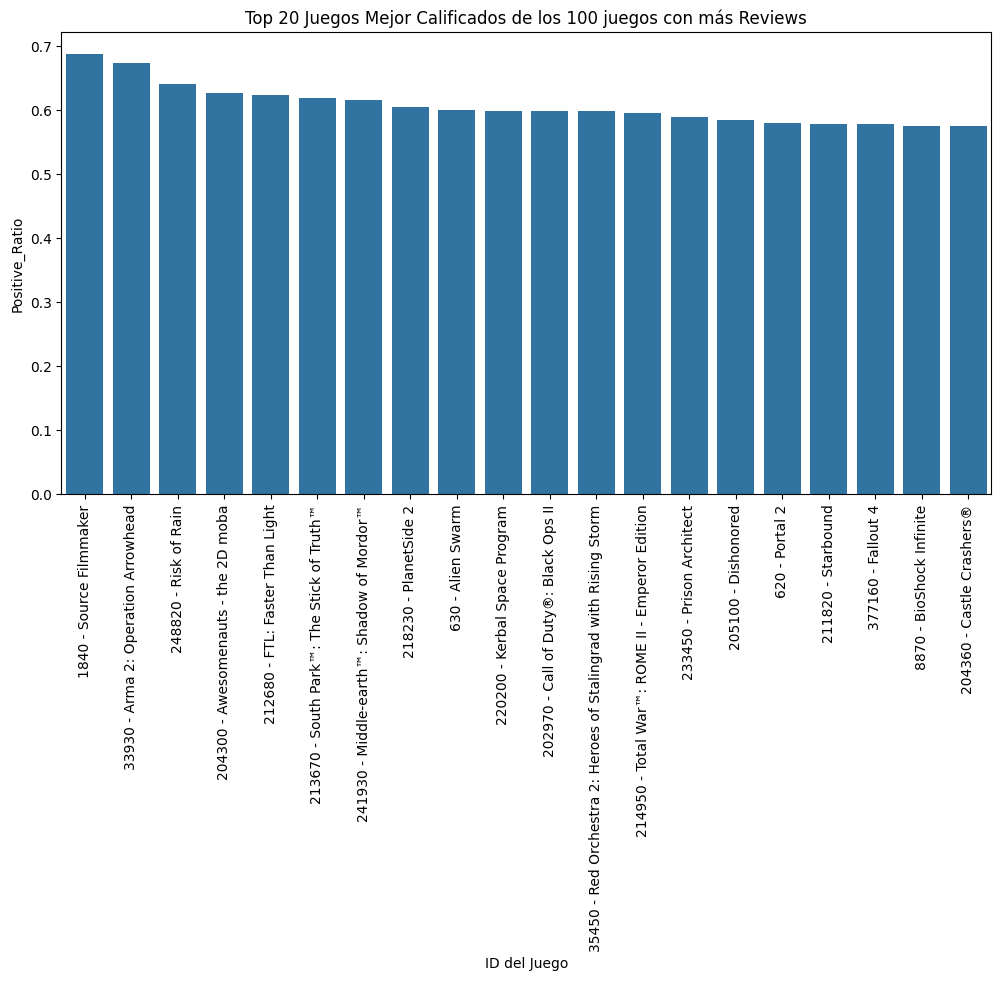

In [274]:
# Primero me quedo con los 100 juegos con más reviews
top_20_count_reviews = df_steam_games.sort_values(by='total_reviews', ascending=False).head(100)

# Los ordeno por mejor ratio positivo y me quedo con los mejores 20
top_20_count_reviews = top_20_count_reviews.sort_values(by='positive_ratio', ascending=False).head(20)

# Crear una nueva columna que combine 'item_id' y 'title'
top_20_count_reviews['game_label'] = top_20_count_reviews['item_id'].astype(str) + ' - ' + top_20_count_reviews['title']

# Graficar la cantidad de tiempo por juego
plt.figure(figsize=(12, 6))
sns.barplot(x= top_20_count_reviews['game_label'] , y=top_20_count_reviews['positive_ratio'])
plt.xticks(rotation=90)
plt.title('Top 20 Juegos Mejor Calificados de los 100 juegos con más Reviews')
plt.xlabel('ID del Juego')
plt.ylabel('Positive_Ratio')
plt.show()

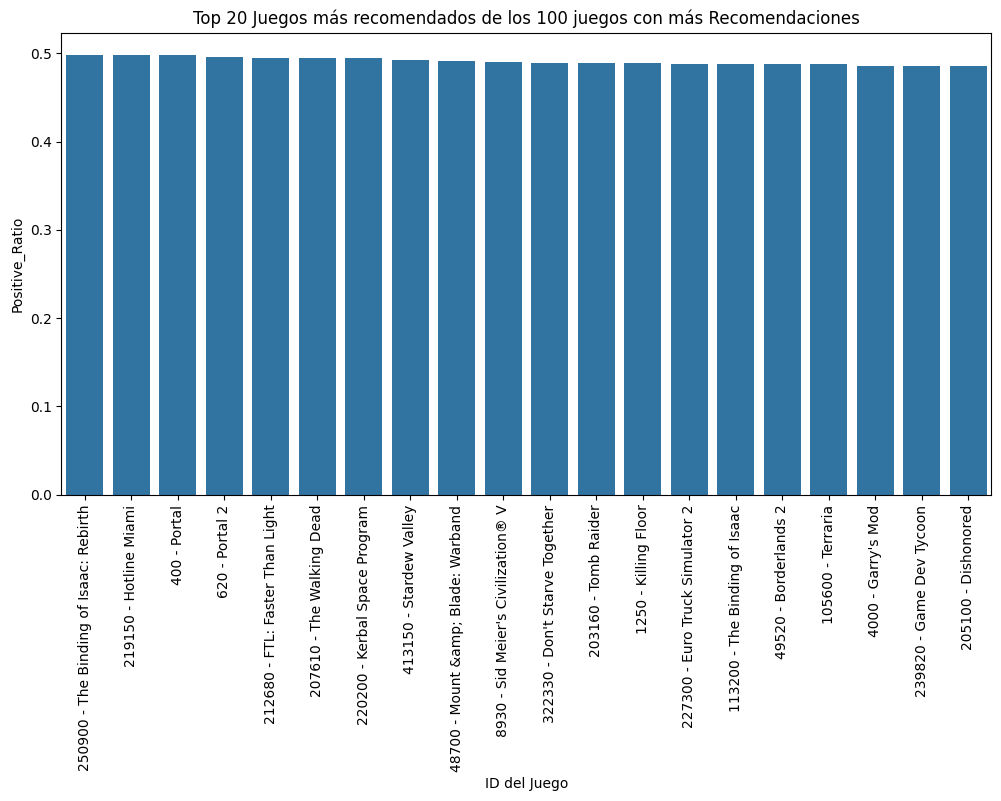

In [275]:
# Primero me quedo con los 100 juegos con más reviews
top_20_count_reviews = df_steam_games.sort_values(by='total_recommend', ascending=False).head(100)

# Los ordeno por mejor ratio positivo y me quedo con los mejores 20
top_20_count_reviews = top_20_count_reviews.sort_values(by='true_ratio', ascending=False).head(20)

# Crear una nueva columna que combine 'item_id' y 'title'
top_20_count_reviews['game_label'] = top_20_count_reviews['item_id'].astype(str) + ' - ' + top_20_count_reviews['title']

# Graficar la cantidad de tiempo por juego
plt.figure(figsize=(12, 6))
sns.barplot(x= top_20_count_reviews['game_label'] , y=top_20_count_reviews['true_ratio'])
plt.xticks(rotation=90)
plt.title('Top 20 Juegos más recomendados de los 100 juegos con más Recomendaciones')
plt.xlabel('ID del Juego')
plt.ylabel('Positive_Ratio')
plt.show()

# ANÁLISIS MULTIVARIABLE:

- Análisis de positive_ratio vs true_ratio y de negative_ratio vs false_ratio

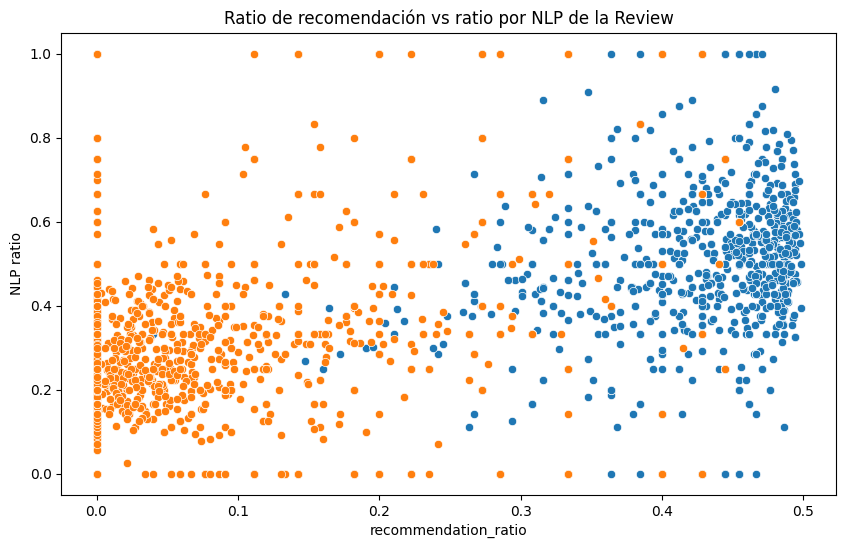

In [276]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x= 'true_ratio', y='positive_ratio', data = df_steam_games)
sns.scatterplot(x= 'false_ratio', y='negative_ratio', data = df_steam_games)
plt.title('Ratio de recomendación vs ratio por NLP de la Review')
plt.xlabel('recommendation_ratio')
plt.ylabel('NLP ratio')
plt.show()

- Análisis de precio vs positive_ratio

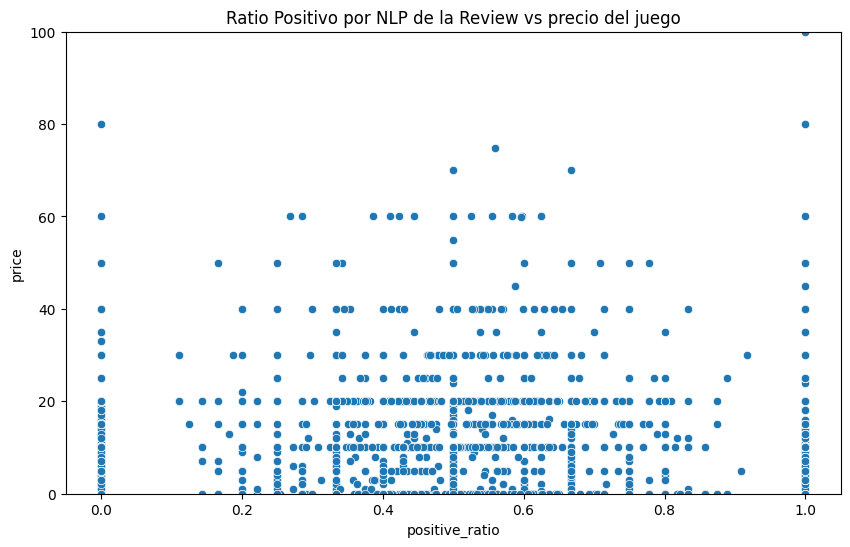

In [277]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x= 'positive_ratio', y='price', data = df_steam_games)
plt.title('Ratio Positivo por NLP de la Review vs precio del juego')
plt.xlabel('positive_ratio')
plt.ylabel('price')
plt.ylim(0,100)
plt.show()

- Análisis de precio vs true_ratio

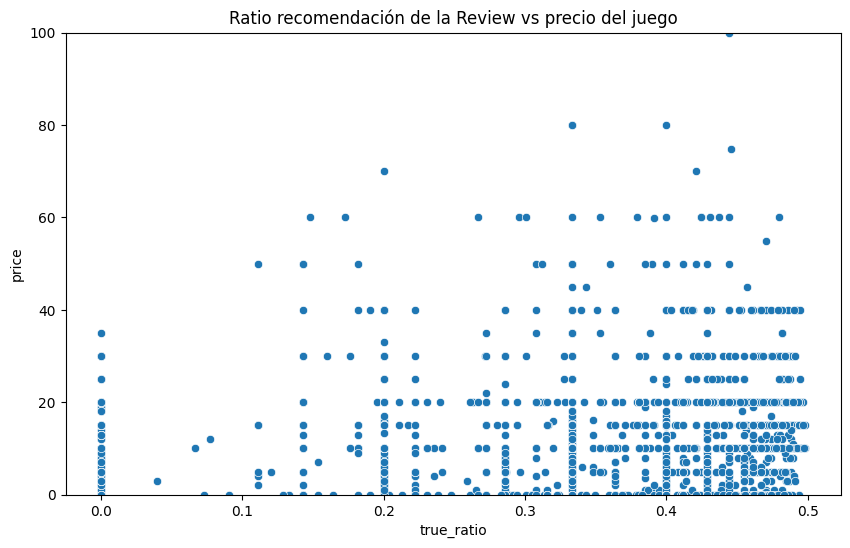

In [278]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x= 'true_ratio', y='price', data = df_steam_games)
plt.title('Ratio recomendación de la Review vs precio del juego')
plt.xlabel('true_ratio')
plt.ylabel('price')
plt.ylim(0,100)
plt.show()

- Análisis de precio vs tiempo jugado

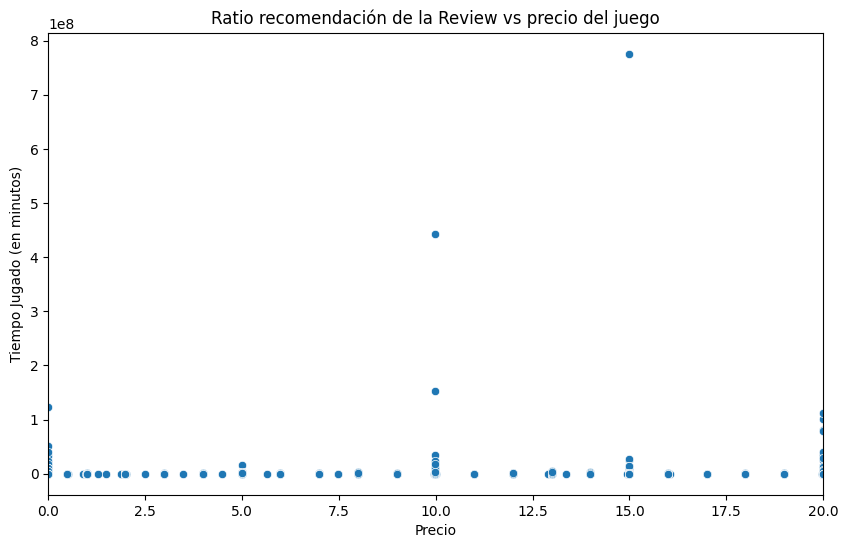

In [279]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x= 'price', y='playtime_forever', data = df_steam_games)
plt.title('Ratio recomendación de la Review vs precio del juego')
plt.xlabel('Precio')
plt.ylabel('Tiempo Jugado (en minutos)')
plt.xlim(0,20)
plt.show()

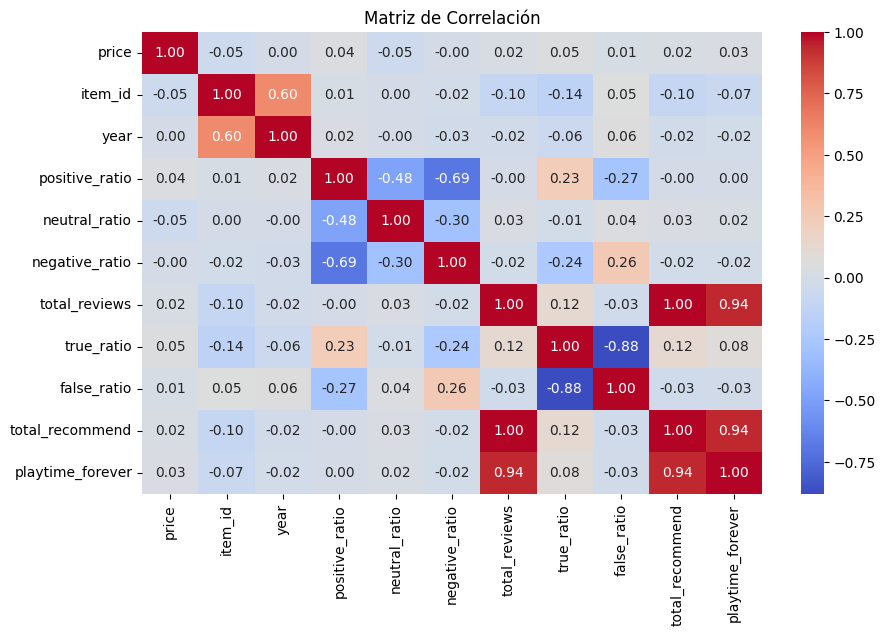

In [280]:
# Seleccionar solo columnas numéricas
numerical_df = df_steam_games.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación
correlation_matrix = numerical_df.corr()

# Graficar la matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

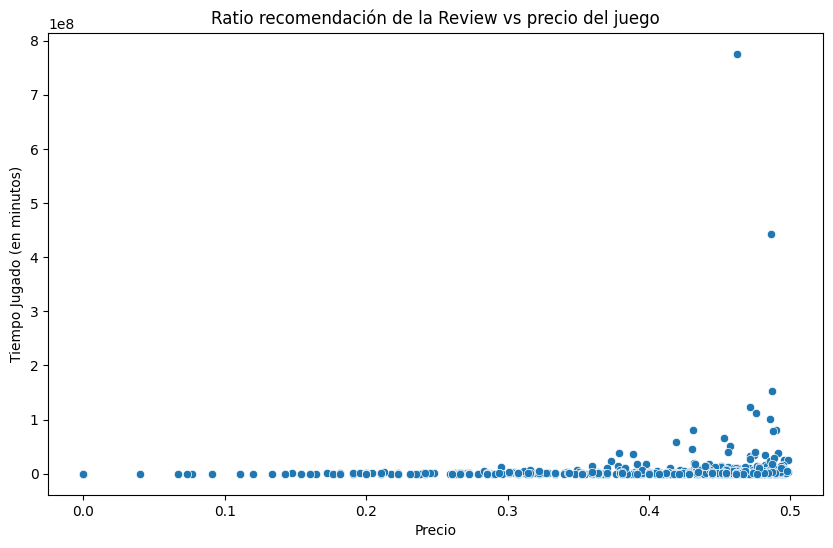

In [281]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x= 'true_ratio', y='playtime_forever', data = df_steam_games)
plt.title('Ratio recomendación de la Review vs precio del juego')
plt.xlabel('Precio')
plt.ylabel('Tiempo Jugado (en minutos)')
plt.show()

- Nube de palabras con los nombres de los juegos

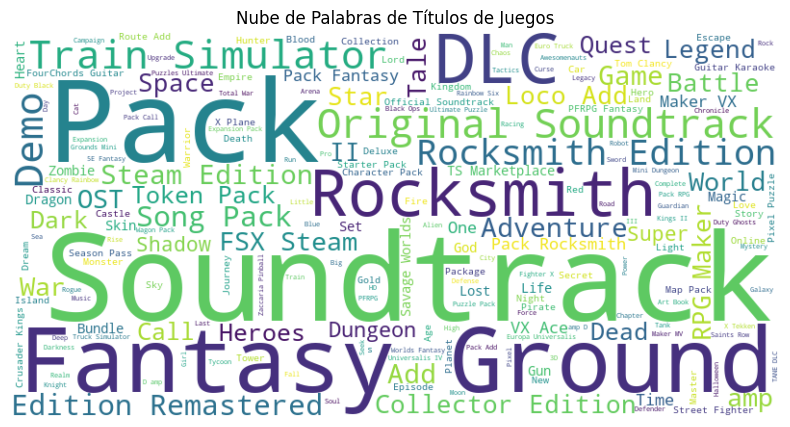

In [250]:
# Concatenar todos los títulos en una sola cadena
text = ' '.join(df_steam_games['title'].dropna())

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Oculta los ejes
plt.title('Nube de Palabras de Títulos de Juegos')
plt.show()

- Nube de palabras con el resultado del procesamiento NLP

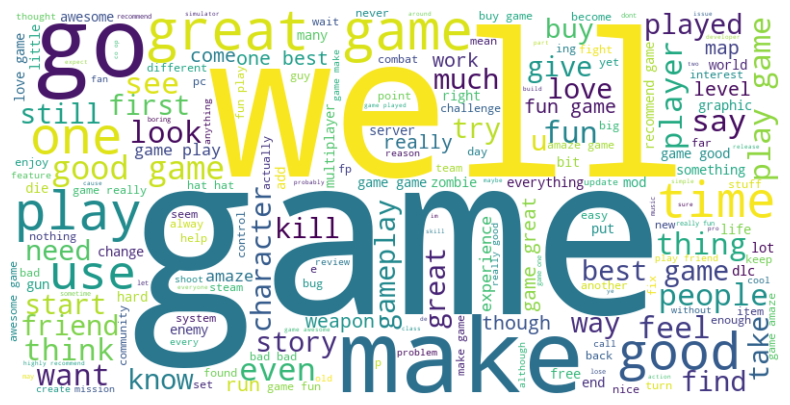

In [252]:
# Convertir los valores de la columna 'processed_reviews' a cadenas de texto y eliminar valores NaN
df_reviews['processed_reviews'] = df_reviews['processed_reviews'].astype(str)

# Función para eliminar caracteres no deseados (como comillas simples o dobles)
def clean_review(review):
    # Eliminar cualquier comilla simple, doble o caracteres especiales
    return re.sub(r"['\"“”‘’]", '', review)

# Aplicar la función de limpieza a cada reseña
df_reviews['processed_reviews'] = df_reviews['processed_reviews'].apply(clean_review)
# Concatenar todas las reseñas en una sola cadena de texto
text = ' '.join(review for review in df_reviews['processed_reviews'].dropna() if isinstance(review, str))

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text)

# Mostrar la nube de palabras con Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Para no mostrar los ejes
plt.show()

In [253]:
df_steam_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28564 entries, 0 to 28563
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   publisher         23668 non-null  object        
 1   genres            28564 non-null  object        
 2   app_name          28563 non-null  object        
 3   title             28563 non-null  object        
 4   url               28564 non-null  object        
 5   release_date      28261 non-null  datetime64[ns]
 6   tags              28542 non-null  object        
 7   reviews_url       28564 non-null  object        
 8   specs             28564 non-null  object        
 9   price             27340 non-null  float64       
 10  early_access      28564 non-null  bool          
 11  item_id           28564 non-null  Int64         
 12  developer         28394 non-null  object        
 13  free              28564 non-null  bool          
 14  year              2826

In [254]:
# Guardo el DF en parquet para levantarlo más rápido la próxima vez.
df_steam_games.to_parquet('..\\datasets\\2. Depurado\\steam_games_postEDA.parquet', index=False)